## Tension Calibration

Here I will use the Planck fiducial cosmology and LSST covariance to generate data vectors near the Planck cosmology.

In [24]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from getdist import plots, MCSamples
import getdist
from multiprocessing import Pool
from getdist import plots, MCSamples

import sys
import time
from cocoa_emu import *
from cocoa_emu.emulator import NNEmulator, GPEmulator
from cocoa_emu.data_model import LSST_3x2

import emcee
import time

# Now normalizing flow
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tf.keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import Callback

from numpy import linalg
import scipy

%matplotlib notebook

In [25]:
# Get the LSST covariance and fid data
path = '/home/grads/data/evan/tension_calibration/data/lsst_y1/'
lsst_cov = np.loadtxt(path+'cov_lsst_y1')
fid_cos = np.loadtxt(path+'lsst_y1_data_fid',dtype=np.float32)[:,1]

In [26]:
lsst_y1_cov = np.zeros((1560, 1560))
for line in lsst_cov:
    i = int(line[0])
    j = int(line[1])

    cov_g_block  = line[-2]
    cov_ng_block = line[-1]

    cov_ij = cov_g_block + cov_ng_block

    lsst_y1_cov[i,j] = cov_ij
    lsst_y1_cov[j,i] = cov_ij
    
fid = torch.Tensor(fid_cos)
cov = torch.Tensor(lsst_y1_cov)

In [27]:
noise_dist = torch.distributions.multivariate_normal.MultivariateNormal(
    loc=fid, covariance_matrix=cov
)

In [28]:
n_samples = 100000

data_set = np.array([noise_dist.sample() for i in range(n_samples)])

/home/grads/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/grads/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we ca

In [29]:
chisq = np.zeros(n_samples)

inv_cov = torch.inverse(cov)
for i in range(n_samples):
    data_vec = data_set[i]-fid
    data_vec_T = np.transpose(data_vec)
    chi2 = np.matmul(data_vec_T,np.matmul(inv_cov,data_vec))
    chisq[i]=chi2

<IPython.core.display.Javascript object>


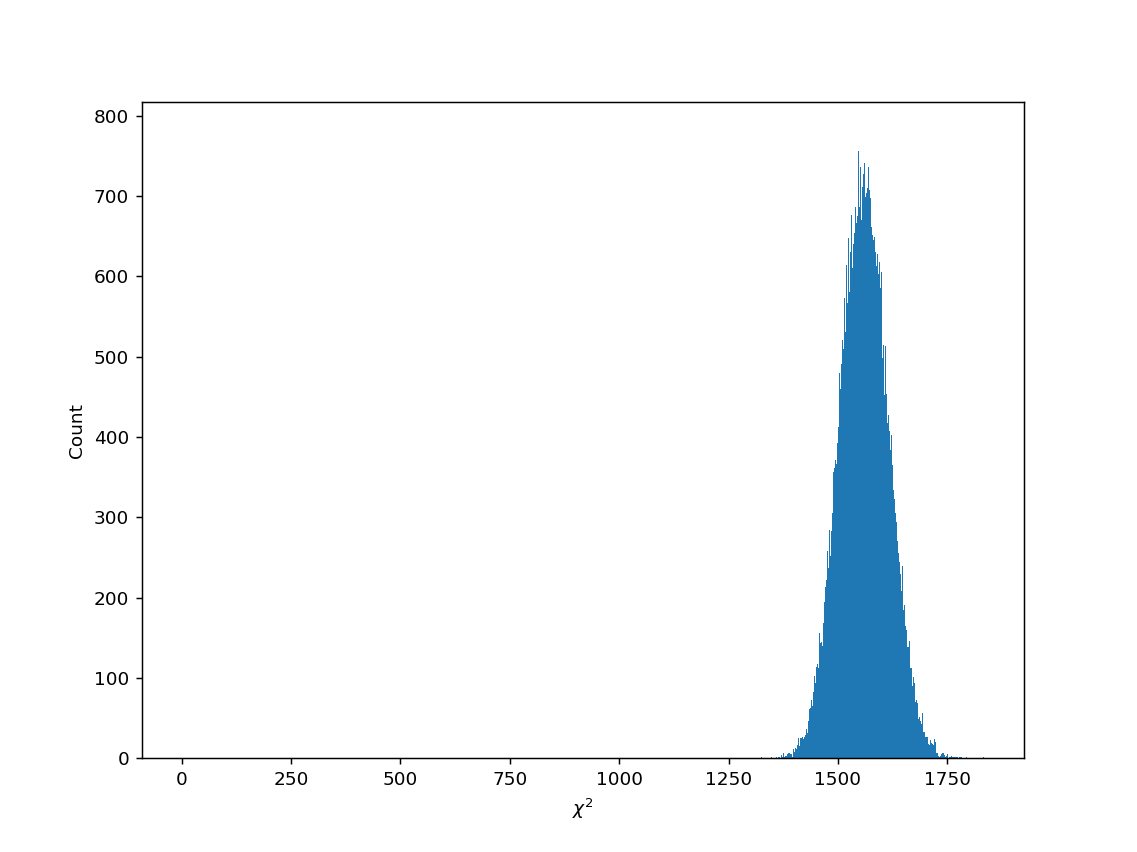

[1530.07385254 1566.25500488 1487.11547852 ... 1532.43945312 1648.97558594
 1480.43225098]


In [30]:
plt.xlabel('$\chi^2$')
plt.ylabel('Count')
plt.hist(chisq,bins=np.arange(0,np.amax(chisq))+1)
plt.show()

print(chisq)

Removed no burn in
[array([1504.36682129, 1615.55322266]), array([1450.32202148, 1673.21850586]), array([1398.99060059, 1730.87438965]), array([1325.38269043, 1832.82092285])]


<IPython.core.display.Javascript object>


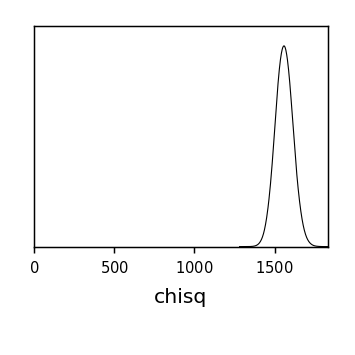

In [31]:
chain = MCSamples(samples=chisq,names=['chisq'])
ttlim = [0.6827,0.9545,0.9973,1]
limits = []
for lim in ttlim:
    limits.append(chain.twoTailLimits(0,lim))
print(limits)

g = plots.get_subplot_plotter()
g.plot_1d(chain, param='chisq',filled=False,lims=[0,np.amax(chisq)+1])

In [32]:
indices = []
for i in range(0,len(limits)):
    indices.append(np.where((chisq > limits[i][0]) 
                            & (chisq < limits[i][1])))
    
#print(indices)
for i in range(len(indices)):
    print(indices[i][0])
    print(len(indices[i][0]))

[    0     1     3 ... 99995 99996 99997]
68268
[    0     1     2 ... 99997 99998 99999]
95449
[    0     1     2 ... 99997 99998 99999]
99728
[    0     1     2 ... 99997 99998 99999]
99998


In [33]:
filtered_ids = [indices[0][0]]
for i in range(len(indices)-1):
    level_1 = indices[i][0]
    level_2 = indices[i+1][0]
    
    for idx in level_1:
        level_2 = level_2[level_2 != idx]
    print(level_1)
    print(level_2)
    filtered_ids.append(level_2)
print('\n\n')
print(filtered_ids[2])
print(filtered_ids[3])

#for i in range(len(filtered_ids)):
    #print(filtered_ids[i])
    #print(len(filtered_ids[i]))


[    0     1     3 ... 99995 99996 99997]
[    2     4    10 ... 99990 99998 99999]
[    0     1     2 ... 99997 99998 99999]
[    7    24   110 ... 99933 99970 99991]
[    0     1     2 ... 99997 99998 99999]
[  306   328   386   424   491   499   787  1591  2320  2322  2564  3092
  3153  3196  3750  4342  4696  4918  4980  5059  5453  6327  6345  6856
  7108  7480  8129  8208  8522  9545  9641  9773  9945 10451 10620 11532
 12726 12979 13097 13253 13276 13941 14211 15164 15244 15544 15829 16119
 17366 17401 18348 18351 18366 18607 18640 19187 19751 20360 21106 21208
 21426 21449 21867 21910 21930 21937 22714 23665 23717 24108 25043 25283
 25934 26174 26958 27388 27897 27937 28203 28474 28797 28846 29480 29734
 29853 30253 30415 30578 30904 30972 31531 31682 31814 32203 32633 33015
 33098 33349 33799 35265 35832 36015 36025 37602 37760 37793 37856 37929
 38096 38937 39192 39634 39833 40265 40316 40852 41252 42198 42413 42426
 42439 42558 43178 43942 44089 45241 45305 46285 46484 46564

In [34]:
_savedir = '/home/grads/data/evan/tension_calibration/dvs/'
# Now I want to save each of the data vectors in csv format
for i in range(len(ttlim)):
    print(ttlim[i])
    _dv = []
    
    # uncomment this if you want to save ALL data vectors
    ########
    #for j in filtered_ids[0]:
    #    _dv.append(data_set[j].numpy())
    ########
    
    # uncomment to save N random data vectors
    ########
    N=40
    ids = np.arange(len(filtered_ids[i]))
    print(ids)
    np.random.shuffle(ids)
    print(ids)
    ids = ids[:N]
    print(ids)
    idx = [filtered_ids[i][ids[j]] for j in range(N)]
    ########
    
    _dv = [data_set[idx[j]].numpy() for j in range(N)]
    
    np.savetxt(_savedir+"noisy_dv_"+str(ttlim[i])+'.csv', np.array(_dv), delimiter=",")
print('Data vectors save in: '+_savedir)

0.6827
[    0     1     2 ... 68265 68266 68267]
[55205 47286  6533 ... 51205 66110  2453]
[55205 47286  6533 44328 30224  4594 14251 38147 62713 52590 17793  9755
 23199 42958 57360 21163  2073 13577 66251 46510 57124 54766 32766 35511
  3892 47126 50368 12899 56212 55786 56074 16776 47285  5735 15218 39566
 63105 35733 40267 32858]
0.9545
[    0     1     2 ... 27178 27179 27180]
[ 2774 13036  5285 ... 25397   721 18191]
[ 2774 13036  5285  2136 19001 24346 19435  5519  8021 19004 18236 18685
 11097  5428 21545  3824 23377  9315 23427 14270  5415 23213  8288  8514
 23481   219  1216  6677 16917  2289 22855 25557 24829 20913 11842 16231
 10277 25287   383 19419]
0.9973
[   0    1    2 ... 4276 4277 4278]
[2031  238 3299 ... 3119 1820 4033]
[2031  238 3299 2035  599  123 2721 2937 2786 1610 1272 1356 1526  449
   49 1996  562 1742 2588 1564   54 3056 2979 1953 3197 3695  230 3465
 1072 2851 1809 1389  900  802 3767 3298 1602 2922 2420 1249]
1
[  0   1   2   3   4   5   6   7   8   9  1